[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1iEqy90iQalQ2LKjmUbislKXGdm91usb8)

# Notebook #3: tweet sentiment analysis

## Description and requirements:

In this notebook, you will learn how to perform sentiment analysis on tweets extracted from Twitter in Python.

A requirement for this code to work is to have the English version of the Hedonomoter word list, which can be downloaded from [Hedonometer](https://hedonometer.org/). This dataset contains a list of words, in which each word is assigned a "happiness score". This happiness score varies between 1 and 9, with 1 being very negative and 9 being very positive. For example the word `coronavirus` received the value of 1.34, while the word `laughter` received 8.5. 

The method we will use here to measure the sentiment of one tweet is to add up the happiness scores of each word contained in the tweet and divide the total score by the number of words in the tweet.


### Import modules

In [1]:
import os
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

path_to_data = './data'
path_to_timelines = os.path.join(path_to_data, 'timelines')
path_to_sentiment = os.path.join(path_to_data, 'sentiment')
hedonometer_path = os.path.join(path_to_data, 'Hedonometer.csv')

os.makedirs(path_to_sentiment, exist_ok=True)

e:\workspace\python\python troject\venv\lib\site-packages\tqdm\std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Define initial functions

First, we will define a function to save data.

#### save

This function will take as an input:
- `df` The DataFrame to save
- `path` The path to save the file
- `name` The name of the saved file

This function will then save the content of the `df` to a local file in `path/name` that we could read later and work on.

In [2]:
def save(df, path, name):
    df.to_pickle(os.path.join(path, f'{name}.pkl'))

Now that we can save files, we will define a few extra functions that will be used for the sentiment analysis.

#### sentiment
This function will determine the sentiment of a tweet.
It will take as an input:
- `sentence` which is the tweet to analyze.

It then goes over all words in the sentence and compute the average happiness score of all words that appear in the Hedonometer dataset.

In [3]:
def sentiment(sentence):
    senti = 0
    total = 0
    words = sentence.split(" ")
    for word in words:
        if word in scores.keys():
            senti += scores[word]
            total += 1
    try:
        return senti / total
    except ZeroDivisionError:
        return 0

#### standard_deviation
This function will determine the standard deviation of a tweet.
In statistics, the standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range.

It will take as an input:
- `sentence` which is the sentence (Tweet) to analyze

It then goes over all words in the sentence and compute the average standard deviation of all words that appear in the Hedonometer dataset.

In [4]:
def standard_deviation(sentence):
    standard_deviation = 0
    total = 0
    words = sentence.split(" ")
    for word in words:
        if word in sds.keys():
            standard_deviation += sds[word]
            total += 1
    try:
        return standard_deviation / total
    except ZeroDivisionError:
        return 0

#### grab_hits
This function will catch all the matched words from the tweet that appear on the hedonometer.

It will take as an input:
- `sentence` which is the sentence (Tweet) to analyze

It then goes over all words in the sentence, tries to match them with the hedonometer list, and returns the ones that were found.

In [5]:
def grab_hits(sentence):
    hits = []
    words = sentence.split(" ")
    for word in words:
        if word in sds.keys():
            hits.append(word)
    return hits

Now, we would like to do this for each of the tweets in our df. To do this, we will use the `apply` method of a df.
This method will run the functions `sentiment`, `standard_deviation`, and `grab_hits` on each of the tweets.
After running, it will convert the result to a Pandas series and return it.

In [6]:
# Run sentiment on each tweet
def return_sentiment(df):
    return pd.Series(df["clean_text"].apply(lambda x: sentiment(x)))

# Run standard_deviation on each tweet
def return_standard_deviation(df):
    return pd.Series(df["clean_text"].apply(lambda x: standard_deviation(x)))

# Run grab_hits on each tweet
def return_hits(df):
    return pd.Series(df["clean_text"].apply(lambda x: grab_hits(x)))

### Import translation tools from Notebook #2

Since the tweets can be in different languages, we will use the translation method that we covered in [Notebook #2: machine translation](2-machine-translation.ipynb).


In [7]:
import transformers
from transformers import MarianMTModel, MarianTokenizer
from transformers.hf_api import HfApi

In [8]:
transformers.__version__

'4.0.1'

In [9]:
class Translator:

    def __init__(self, src_language, tgt_language):
        self.src_language = src_language
        self.tgt_language = tgt_language
        self.model_name = f'Helsinki-NLP/opus-mt-{src_language}-{tgt_language}'
        model_list = HfApi().model_list()
        org = "Helsinki-NLP"
        self.valid_model_names = [x.modelId for x in model_list if x.modelId.startswith(org)]
        if self.model_name not in self.valid_model_names:
            raise KeyError(f'{self.model_name} is not a valid model name.')

    def load_model(self):
        """Load translation model and tokenizer."""
        tokenizer = MarianTokenizer.from_pretrained(self.model_name)
        model = MarianMTModel.from_pretrained(self.model_name)
        return tokenizer, model

    def translate(self, src_text, loaded_model):
        """Use loaded model and tokenizer to translate the source text."""
        tokenizer, model = loaded_model
        translated = model.generate(**tokenizer.prepare_seq2seq_batch([src_text], return_tensors="pt"))
        return [tokenizer.decode(t, skip_special_tokens=True) for t in translated][0]

Now, we load our Translator model with Urdu as source language and English as target language.

In [10]:
translator = Translator('ur', 'en')
model = translator.load_model()

### Define cleaning functions

In order to clean our tweets from URLs, prefixes and more, we will define the following functions:

#### remove_pattern
This function will remove a given pattern from the text using regular expression.

It will take as an input:
- `input_txt` The input text to remove
- `pattern` The pattern to remove

It will then return the cleaned text.

In [11]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

#### remove_prefix
This function will remove a prefix from a given text.

It will receive as input:
- `text` The text to remove the prefix from
- `prefix` The prefix to remove

It will then return the cleaned text.

In [12]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        text = text.replace(prefix, "", 1)
    return text

#### clean_and_translate
It will clean the tweets from the df using the above functions.
This function will receive:
- `df` the DataFrame containing all the tweets

It will create a new column called `clean_text` in the df that will contain all the clean and translated tweets.

In [13]:
def clean_and_translate(df):
    # Remove all url's from the tweet
    df['clean_text'] = df['full_text'].str.replace('http\S+|www.\S+', '', case=False)
    # Remove all \n from text
    df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], "\n")
    # Remove all @ tags
    df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], "@[\w]*")
    # Remove all RT prefix
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_prefix(x, "RT : "))
    #remove all # tags
    df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], r"#(\w+)")
    # Remove all # from it
    df['clean_text'] = df['clean_text'].str.replace('#', '')
    # Make the string lower case
    df['clean_text'] = df['clean_text'].str.lower()
    # remove all the punctuation
    df['clean_text'] = df.clean_text.str.replace(r'[^\w\s]', '')
    # If some tweets were left empty then remove them
    df = df[df['clean_text'] != '']
    # Translate the tweets and return the DataFrame
    df['clean_text'] = df['clean_text'].apply(lambda text: translator.translate(text, model))
    return df

### Load Hedonometer data

Finally, we can load our Hedonometer and start calculating the sentiments of the tweets.
First, we will load the Hedonometer scores and store them in a dictionary. Each entry will be in the form of {key: value}, where `key` stands for a word from the list and `value` will be the sentiment score given to it.

In [14]:
file = pd.read_csv(hedonometer_path).sort_values(by='Happiness Score')
scores = file[["Word", "Happiness Score"]]
scores.columns = ["word", "score"]
scores = dict(zip(scores.word, scores.score))

In [15]:
file.head()

,Rank,Word,Word in English,Happiness Score,Standard Deviation of Ratings
10168,10168,suicide,suicide,1.30,0.84
10169,10169,terrorist,terrorist,1.30,0.91
10171,10171,coronavirus,coronavirus,1.34,0.66
10167,10167,rape,rape,1.44,0.79
10165,10165,murder,murder,1.48,1.01


In [16]:
file.tail()

,Rank,Word,Word in English,Happiness Score,Standard Deviation of Ratings
4,4,laughed,laughed,8.26,1.16
3,3,happy,happy,8.30,0.99
2,2,love,love,8.42,1.11
1,1,happiness,happiness,8.44,0.97
0,0,laughter,laughter,8.50,0.93


Second, we will load the deviation scores.
Again, we will create a dictionary where each entry will be in the form of {key: value}, where `key` stands for a word from the list and `value` will be the standard deviation given to it.
Using the same file, we create a dictionary of words and standard deviations of scores.

In [17]:
sds = file[["Word", "Standard Deviation of Ratings"]]
sds.columns = ["word", "deviation"]
sds = dict(zip(sds.word, sds.deviation))

### Example on Pakistani tweets

Now, let's run an example on Pakistani tweets we downloaded in [Notebook #1](1-download-from-twitter-api.ipynb)
In addition we will use another set of tweets sent from Alabama, USA by downloading the timelines of 200 random users.

First we will load out data and take a look at the data

In [18]:
# Open all Urdu translated tweets from the timelines directory
ur_df = pd.read_pickle(os.path.join(path_to_timelines, 'pakistan.pkl'))

In [19]:
en_df = pd.read_pickle(os.path.join(path_to_timelines, 'usa.pkl'))

In [20]:
ur_df.shape

(1164, 35)

In [21]:
en_df.shape

(112781, 35)

In [22]:
# Print the first 5 items
ur_df['full_text'].head()

0    @MuradSaeedPTI بارش درجن آلو سے نکل کر دیکھو ن...
1    پلٹ کر جواب دینا بیشک غلط ھے لیکن سنتے رہو تو ...
2    @Anosha11593895 زبان پر قابو رکھنا مشکل ضرور ھ...
3    Silence Is the best Answer of All stupids Ques...
4    خیالات گہرے رکھو....کردار میں عاجزی خودبخود آئ...
Name: full_text, dtype: object

In [23]:
# print a single user from the data
print(ur_df.iloc[0]['user'])

{'id': 1292031528814419970, 'id_str': '1292031528814419970', 'name': 'Atif @👉چوہدری', 'screen_name': 'Atii_Jee', 'location': '', 'description': "I'm not attractive but definitely interesting👌❤", 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 773, 'friends_count': 672, 'listed_count': 0, 'created_at': 'Sat Aug 08 09:36:10 +0000 2020', 'favourites_count': 171, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 102, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_image_url_https': None, 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1348953437006868481/FEFCPg-b_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1348953437006868481/FEFCPg-b_normal.jpg', 'profile_banner_url': 'ht

In [24]:
# Extract the username of each user from the user column
ur_df['name'] = ur_df['user'].apply(lambda user: user['name'])
en_df['name'] = en_df['user'].apply(lambda user: user['name'])

In the Pakistan dataset:
- Total of 1164 tweets in our dataset.
- The oldest tweet is from: Aug 14 2020.
- the most recent tweet is from: Oct 28 2020.
- Total of 21 unique users.

In the USA set we have:
- Total of 112781 tweets.
- The oldest tweet is from: Apr 05 2020.
- the most recent tweet is from: Oct 28 2020.
- Total of 113 unique users.

In [25]:
print(f"The oldest tweet is from: {ur_df['created_at'].min()}.")
print(f"The most recent tweet is from: {ur_df['created_at'].max()}.")
print(f"We have a total of {len(ur_df)} tweets.")
print(f"We have a total of {len(ur_df['name'].unique())} unique users.")

The oldest tweet is from: Fri Aug 14 08:12:07 +0000 2020.
The most recent tweet is from: Wed Oct 28 10:26:29 +0000 2020.
We have a total of 1164 tweets.
We have a total of 21 unique users.


In [26]:
print(f"The oldest tweet is from: {en_df['created_at'].min()}.")
print(f"The most recent tweet is from: {en_df['created_at'].max()}.")
print(f"We have a total of {len(en_df)} tweets.")
print(f"We have a total of {len(en_df['name'].unique())} unique users.")

The oldest tweet is from: 2020-04-05 00:00:09+00:00.
The most recent tweet is from: 2020-10-28 23:58:01+00:00.
We have a total of 112781 tweets.
We have a total of 113 unique users.


We then clean our tweets, and translate them to English if they are written in Urdu.

In [27]:
# Clean input and translate if needed
ur_df = clean_and_translate(ur_df)
en_df = clean_and_translate(en_df)
print(ur_df['clean_text'].head())

0    Looking back from the rain table, why we broug...
1    Turn back and say, it's wrong to listen, but t...
2    It is difficult to control the tongue, but it ...
3    Dynamicies are displayed by DClostine Laplick ...
4            The thoughts will be humble in deeperent.
Name: clean_text, dtype: object


We now calculate the sentiment of each tweet. As mentioned earlier, the method used to measure the sentiment of one tweet is to add up the happiness scores of each word contained in the tweet and divide the total score by the number of words in the tweet.

In [28]:
# Run the hedonometer on the tweets
ur_df["hedonometer"] = return_sentiment(ur_df)
en_df["hedonometer"] = return_sentiment(en_df)
# Clear all tweets with no score
ur_df = ur_df[ur_df["hedonometer"] != 0]
en_df = en_df[en_df["hedonometer"] != 0]
# Calculate the standard deviation for each tweets sentiment
ur_df["hedo_sd"] = return_standard_deviation(ur_df)
en_df["hedo_sd"] = return_standard_deviation(en_df)
# Run function to pull the words from each tweet that determine sentiment into a new column
ur_df["hits"] = return_hits(ur_df)
en_df["hits"] = return_hits(en_df)
# Save tweets with sentiments
save(ur_df, path_to_sentiment, 'pakistan_sentiment')
save(en_df, path_to_sentiment, 'usa_sentiment')

### Define functions to plot results:

We define a few functions to produce our final results and plot them.
#### get_mean_based_on_frequency
This function will calculate the mean sentiment of a DataFrame based on a given frequency.

This function will receive:
- `df` A DataFrame of the tweets
- `freq` A frequency of the tweets, default value is daily. For more information about this please visit [time-date-components](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components)
- `start_date` Start date for the tweets, default value is `2020-01-01`
- `end_date` End date for the tweets, default value is `2021-01-01`

This function will calculate the mean sentiment of the tweets by a given frequency (e.g. Day, Week, Month, Year, etc.) starting from the `date`.

In [29]:
def get_mean_based_on_frequency(df, freq, start_date='2020-04-01', end_date='2021-01-01'):
    df["created_at"] = pd.to_datetime(df['created_at'])
    df = df.set_index("created_at")
    df = df[['hedonometer']]
    return df.resample(freq).mean()[start_date:end_date]

#### plot_save_to_pdf_and_show

We will need the final function to plot the sentiment and save it in a PDF file for future use:

This function will take as an input:
- `df` The DataFrame to plot and save
- `ylabel` The label of the Y axis
- `xlabel` The label for the X axis
- `title` The plot title that will be used to save the PDF

In [30]:
def plot_save_to_pdf_and_show(df, ylabel, xlabel, title):
    axes = df.plot(marker='', alpha=1, linestyle='-', figsize=(25, 10), subplots=False, legend=True)
    axes.set_ylabel(ylabel, fontsize=14)
    axes.set_xlabel(xlabel, )
    axes.set_title(title, fontsize=22, pad=20)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.legend(fontsize=14)
    plt.savefig(f"{'_'.join(title.split(' ')).lower()}", dpi=300, bbox_inches="tight",
                transparent=False)
    plt.show()

### Produce and plot final results

Now, we can finally plot our results.
We will plot the mean of all the users that tweeted as well as the top user.

In order to achieve that, we will need to do some work.
We will only take the relevant information:
- `name`
- `created_at`
- `hedonometer` score
- `clean_text`

In [31]:
# Get only the user_id, the time the tweet was created and the hedonometer score
ur_sent_df = ur_df[["name", "created_at", "hedonometer", 'clean_text']]
# Split them to different DataFrames, this will sort the DataFrame by the 'user_id' and sort them
ur_split_df = sorted([pd.DataFrame(y) for x, y in ur_sent_df.groupby('name', as_index=False)], key=len, reverse=True)
print(f"There are {len(ur_split_df)} different users\n"
      f"The user with most tweets is: {ur_split_df[0].iloc[0]['name']} with {len(ur_split_df[0])} tweets\n"
      f"The user with the least tweets is: {ur_split_df[-1].iloc[0]['name']} with {len(ur_split_df[-1])} tweets")

There are 21 different users
The user with most tweets is: itz_mirza_obaid with 620 tweets
The user with the least tweets is: Waqar Ahmed with 1 tweets


In [32]:
# Get only the user_id, the time the tweet was created and the hedonometer score
en_sent_df = en_df[["name", "created_at", "hedonometer", 'clean_text']]
# Split them to different DataFrames, this will sort the DataFrame by the 'user_id' and sort them
en_split_df = sorted([pd.DataFrame(y) for x, y in en_sent_df.groupby('name', as_index=False)], key=len, reverse=True)
print(f"There are {len(en_split_df)} different users\n"
      f"The user with most tweets is: {en_split_df[0].iloc[0]['name']} with {len(en_split_df[0])} tweets\n"
      f"The user with the least tweets is: {en_split_df[-1].iloc[0]['name']} with {len(en_split_df[-1])} tweets")

There are 113 different users
The user with most tweets is: ashley with 10070 tweets
The user with the least tweets is: тоny and 6.9k others with 1 tweets


In [33]:
# Show the first tweet of the user
print(f"the last translated tweet from Pakistan: '{ur_split_df[0].clean_text.loc[7]}'")

the last translated tweet from Pakistan: 'The only ones to enjoy God’s mercy.'


We can see that this tweet is pretty much neutral, but it contains words like mercy and enjoy, so we expect to see a sentiment score of 5 and above.

In [34]:
print(f"the last tweet of the user has a sentiment score of: '{ur_split_df[0].hedonometer.loc[7]}'")

the last tweet of the user has a sentiment score of: '5.68'


In [35]:
# Show the first tweet of the user
print(f"the last tweet from the USA: '{en_split_df[0].clean_text.loc[23256]}'")

the last tweet from the USA: '   at least its not full of titty milk we might be getting divorced'


We can see that this tweet is pretty much neutral, but it contains words like mercy and enjoy, so we expect to see a sentiment score of 5 and above.

In [36]:
print(f"the last tweet of the user has a sentiment score of: '{en_split_df[0].hedonometer.loc[23256]}'")

the last tweet of the user has a sentiment score of: '5.265454545454546'


From this small example we can see that even though the tweets are very much different they are both rather neutral and have a very similar score.

In [37]:
# Take the top user
ur_split_df = ur_split_df[:1]
en_split_df = en_split_df[:1]
# get the id's of the users
ur_user_names = [sdf.iloc[0]['name'] for sdf in ur_split_df]
en_user_names = [sdf.iloc[0]['name'] for sdf in en_split_df]

In [38]:
# Get Daily Mean of each user
ur_split_df = [get_mean_based_on_frequency(sf, start_date='2018-10-01',end_date='2019-01-07', freq='D') for sf in ur_split_df]
en_split_df = [get_mean_based_on_frequency(sf, start_date='2020-06-23',end_date='2020-10-28', freq='D') for sf in en_split_df]
# combine the users, each to its own column
ur_split_sentiment = pd.concat(ur_split_df, axis=1)
en_split_sentiment = pd.concat(en_split_df, axis=1)
# Rename the columns
ur_split_sentiment.columns = ur_user_names
en_split_sentiment.columns = en_user_names
# Get Overall daily mean of tweets
ur_user_sentiment = get_mean_based_on_frequency(ur_sent_df, start_date='2019-04-05', end_date='2020-10-28', freq='D')
us_user_sentiment = get_mean_based_on_frequency(en_sent_df, start_date='2019-04-05', end_date='2020-10-28', freq='D')
# Plot Over all daily sentiment and save it
combine_sentiment = pd.concat([ur_user_sentiment, us_user_sentiment], axis=1).dropna()
combine_sentiment.columns = ['pakistan_sentiment', 'usa_sentiment']
combine_sentiment.head()

e:\workspace\python\python troject\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pakistan_sentiment,usa_sentiment
created_at,,
2020-04-28 00:00:00+00:00,5.680000,5.597749
2020-05-02 00:00:00+00:00,5.680000,5.712153
2020-05-24 00:00:00+00:00,5.806667,5.341415
2020-06-25 00:00:00+00:00,5.210000,5.520105
2020-08-13 00:00:00+00:00,5.540000,5.457700


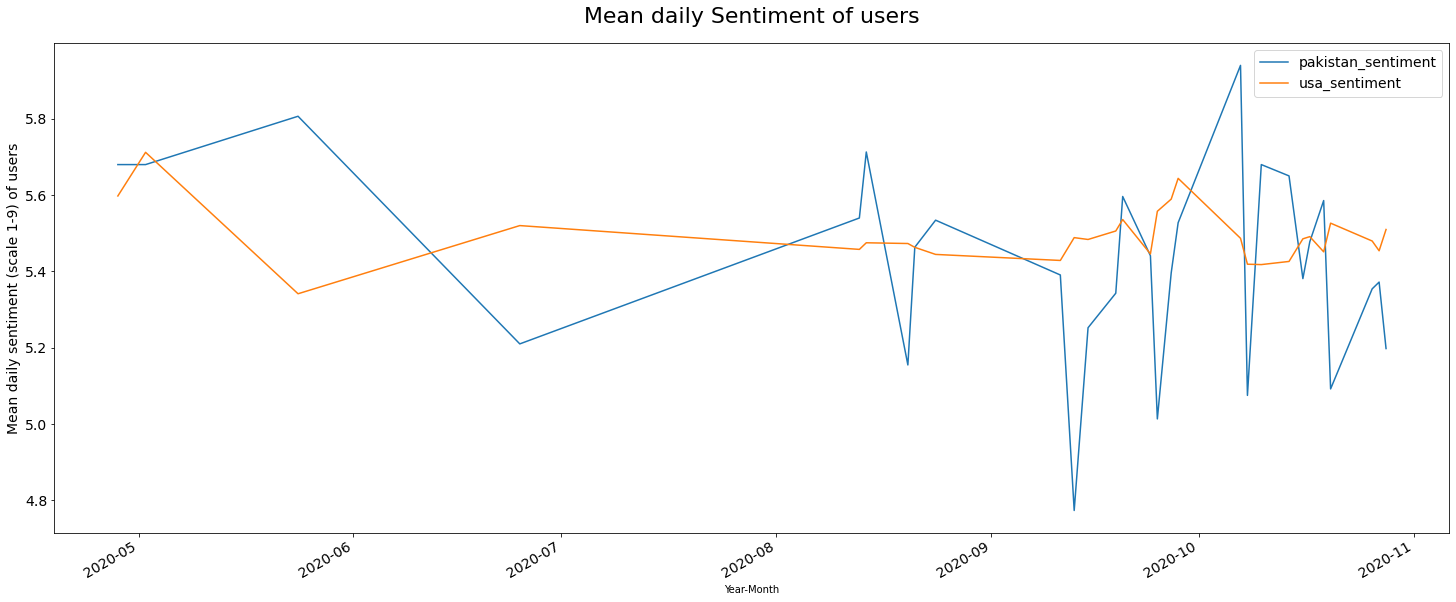

In [42]:
plot_save_to_pdf_and_show(df=combine_sentiment, ylabel='Mean daily sentiment (scale 1-9) of users', xlabel='Year-Month',
                          title='Mean daily Sentiment of users')

This figure shows the average daily sentiment of users from April to November.
We can see from the figure that on average the sentiment ranges between 4.8 to 6.2, which is rather positive.
While on the sample of tweets from the USA we don't see that many leaps in the sentiment score.
We can see that we have fewer tweets (i.e. missing dates) in the timeline and this is why we are getting a single line. In addition, we can also see that toward the end we have a lot more tweets and because of that we can big swings in the sentiment score.

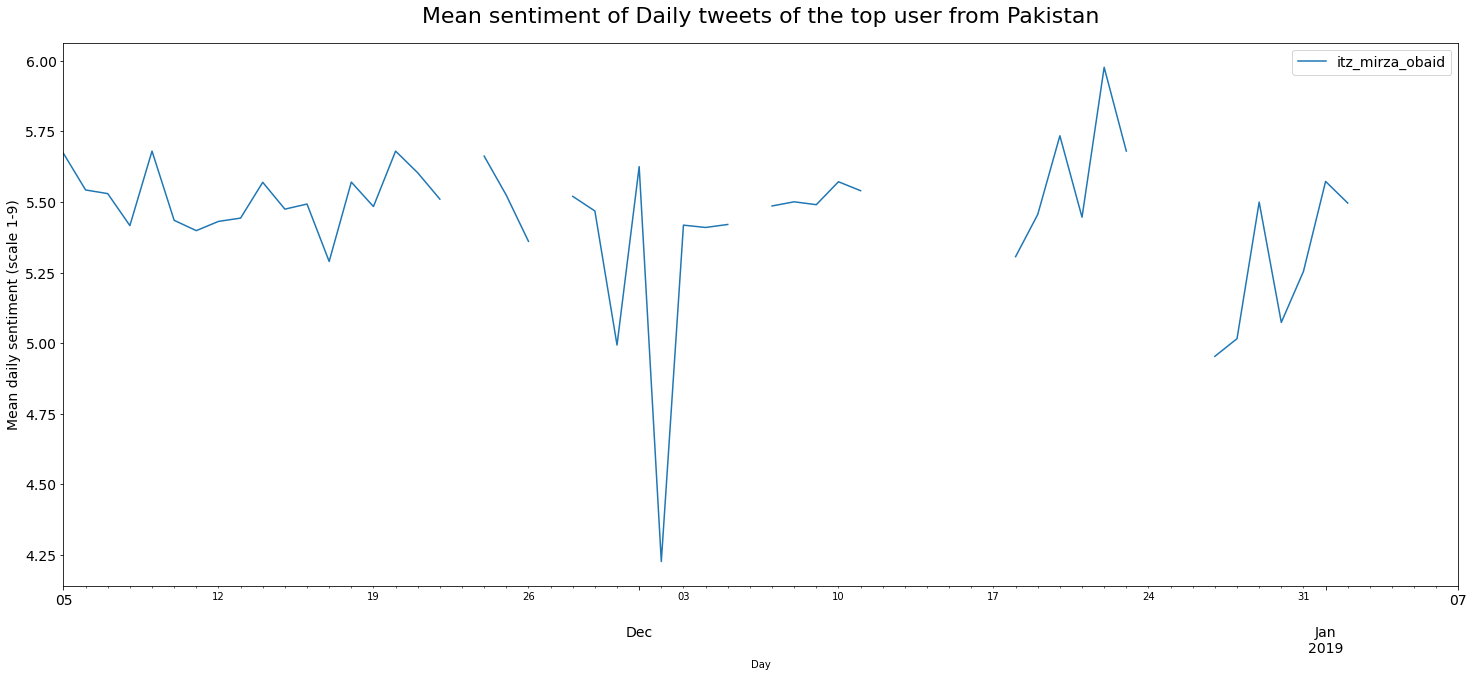

In [43]:
# Plot Key users daily sentiment and save it
plot_save_to_pdf_and_show(df=ur_split_sentiment, ylabel='Mean daily sentiment (scale 1-9)', xlabel='Day',
                          title=f"Mean sentiment of Daily tweets of the top user from Pakistan")

This plot shows the `Top User From Pakistan`, the user with the most tweets from our data, and his average daily sentiment (since this is a small sample, we have a few blanks during the days, those blank mean that the user haven't tweeted).
We can see that the user is rather positive, except for a few tweets that had a really negative content.
The most negative tweet was published on Dec. 2nd 2018 and translated to: "I'll kill you.".
The most positive tweet was published on December 22nd 2018 and read: "while still a few years ago, you're going to have a lot of money."
Note: Since not users are tweeting every day, the time frame we are showing here is the one with the most consecutive tweets.

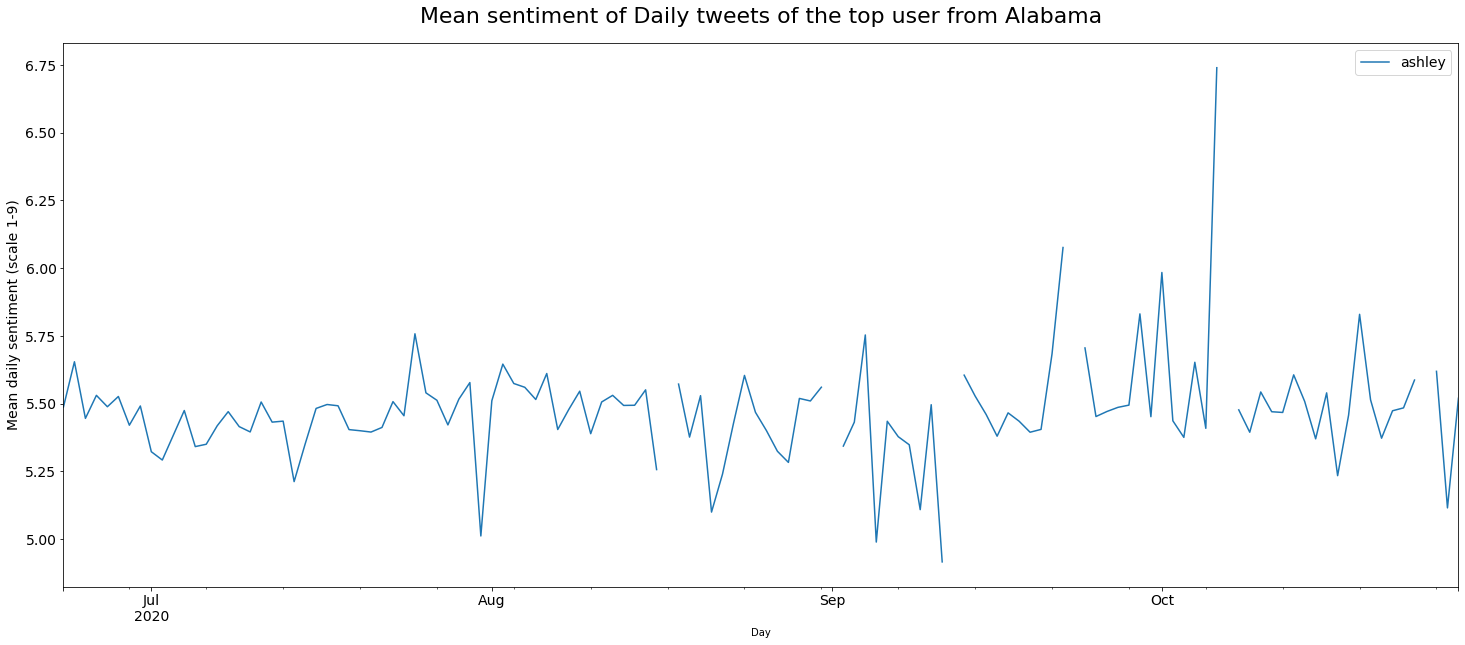

In [44]:
# Plot Key users daily sentiment and save it
plot_save_to_pdf_and_show(df=en_split_sentiment, ylabel='Mean daily sentiment (scale 1-9)', xlabel='Day',
                          title=f"Mean sentiment of Daily tweets of the top user from Alabama")

This plot shows the `Top User From Alabama`, like the user from Pakistan we can see some gaps that are caused by missing days.
We can see that the user is a lot more positive than `itz_mirza_obaid`.
The most negative tweet was published on Sep. 11th 2020: "i didnt even drink at 17 much less murder people".
The most positive tweet was published on Oct. 6th 2020 and read: "  party of family values"
Note: Since not users are tweeting every day, the time frame we are showing here is the one with the most consecutive tweets.